In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from tqdm import tqdm
import os

from P3_helpers import *

In [2]:
# Load data
df = get_dataframe()
df_vote_evolution = get_timeserie_df(df)
df_vote_evolution.sample(5)

,Source,Target,Vote,Results,Year,Date,Comment,Round,Voting_time,Vote_number
156063,FireSpike,Ccool2ax,0,-1.0,2006.0,2006-11-27 18:54:00,'''Neutral''' - I think you need more experien...,1,14.200000,19
126014,Zaheer89,(aeropagitica),-1,1.0,2006.0,2006-03-02 01:58:00,'''Oppose''' as above.,1,49.816667,34
181508,172.162.10.219,Nv8200p,1,1.0,2005.0,2005-09-06 19:09:00,"'''Support''', good editor, seems strongly com...",1,26.766667,8
177447,Darwinek,Howcheng,1,1.0,2005.0,2005-12-22 18:36:00,'''Support'''. Another solid Wikipedian from C...,2,89.350000,66
89440,Ssbohio,Chochopk,1,1.0,2007.0,2007-06-17 02:10:00,'''Support''' Changing my vote per my discussi...,2,168.916667,47


We extract the votes data, then separat them into round of election based on the processing developped in P2. Using these rounds and considering the first vote of each round as the starting time of the round (voting time = 0), we compute the voting time of each vote.

In parallel of the global analysis we also run the same code but for community that we are interested in separatly. This allows us to have a more precise analysis of the voting time for each community, these results are store in the folder "Figure" but are not displayed in the notebook.

In [3]:
# Communities of interest
communities = [[2004, 2], [2005, 3], [2013, 0]]

df_vote_evolution_comm = add_comm_to_df(df_vote_evolution)

In [4]:
# Create folder for plots
if not os.path.exists('Figures'):
    os.makedirs('Figures')

# Sentiment analysis 

To express their support or opposition in the election of a new admin, users can vote for or against a request. So by considering only votes we only have a binary information of voters opinion. To have a more precise and nuanced idea of whether a user is in favor or against a request, we thought of using the comments that users can leave when they vote which can be more indicative of their level of support. To do this, we implement a pipeline for Sentiment Analysis of the comments which allows us to have continuous value between -1 and 1 for each vote.

### Compound score

In [5]:
# Sentiment analysis
df_sentiment = sentiment_analysis(df)
df_sentiment.to_csv('sentiment.csv', index=False)

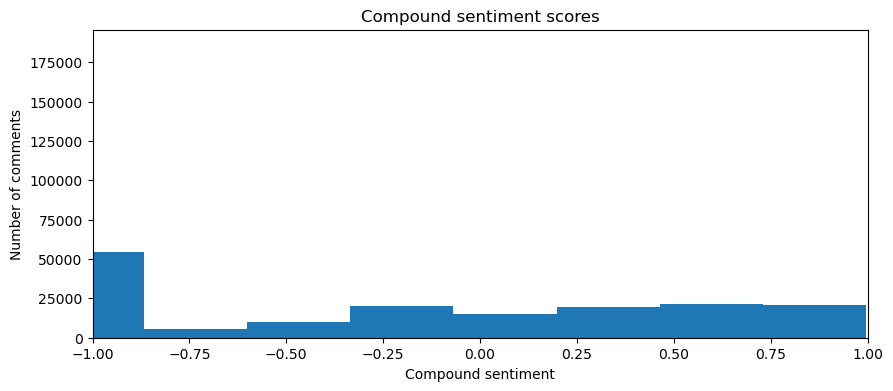

In [ ]:
# Plotting the compound sentiment score distribution of the comments
plot_compound_sentiment_score(df_sentiment)

1/3 des commentaires sont neutres, la majorité des commentaires sont positifs et seul peu sont négatifs

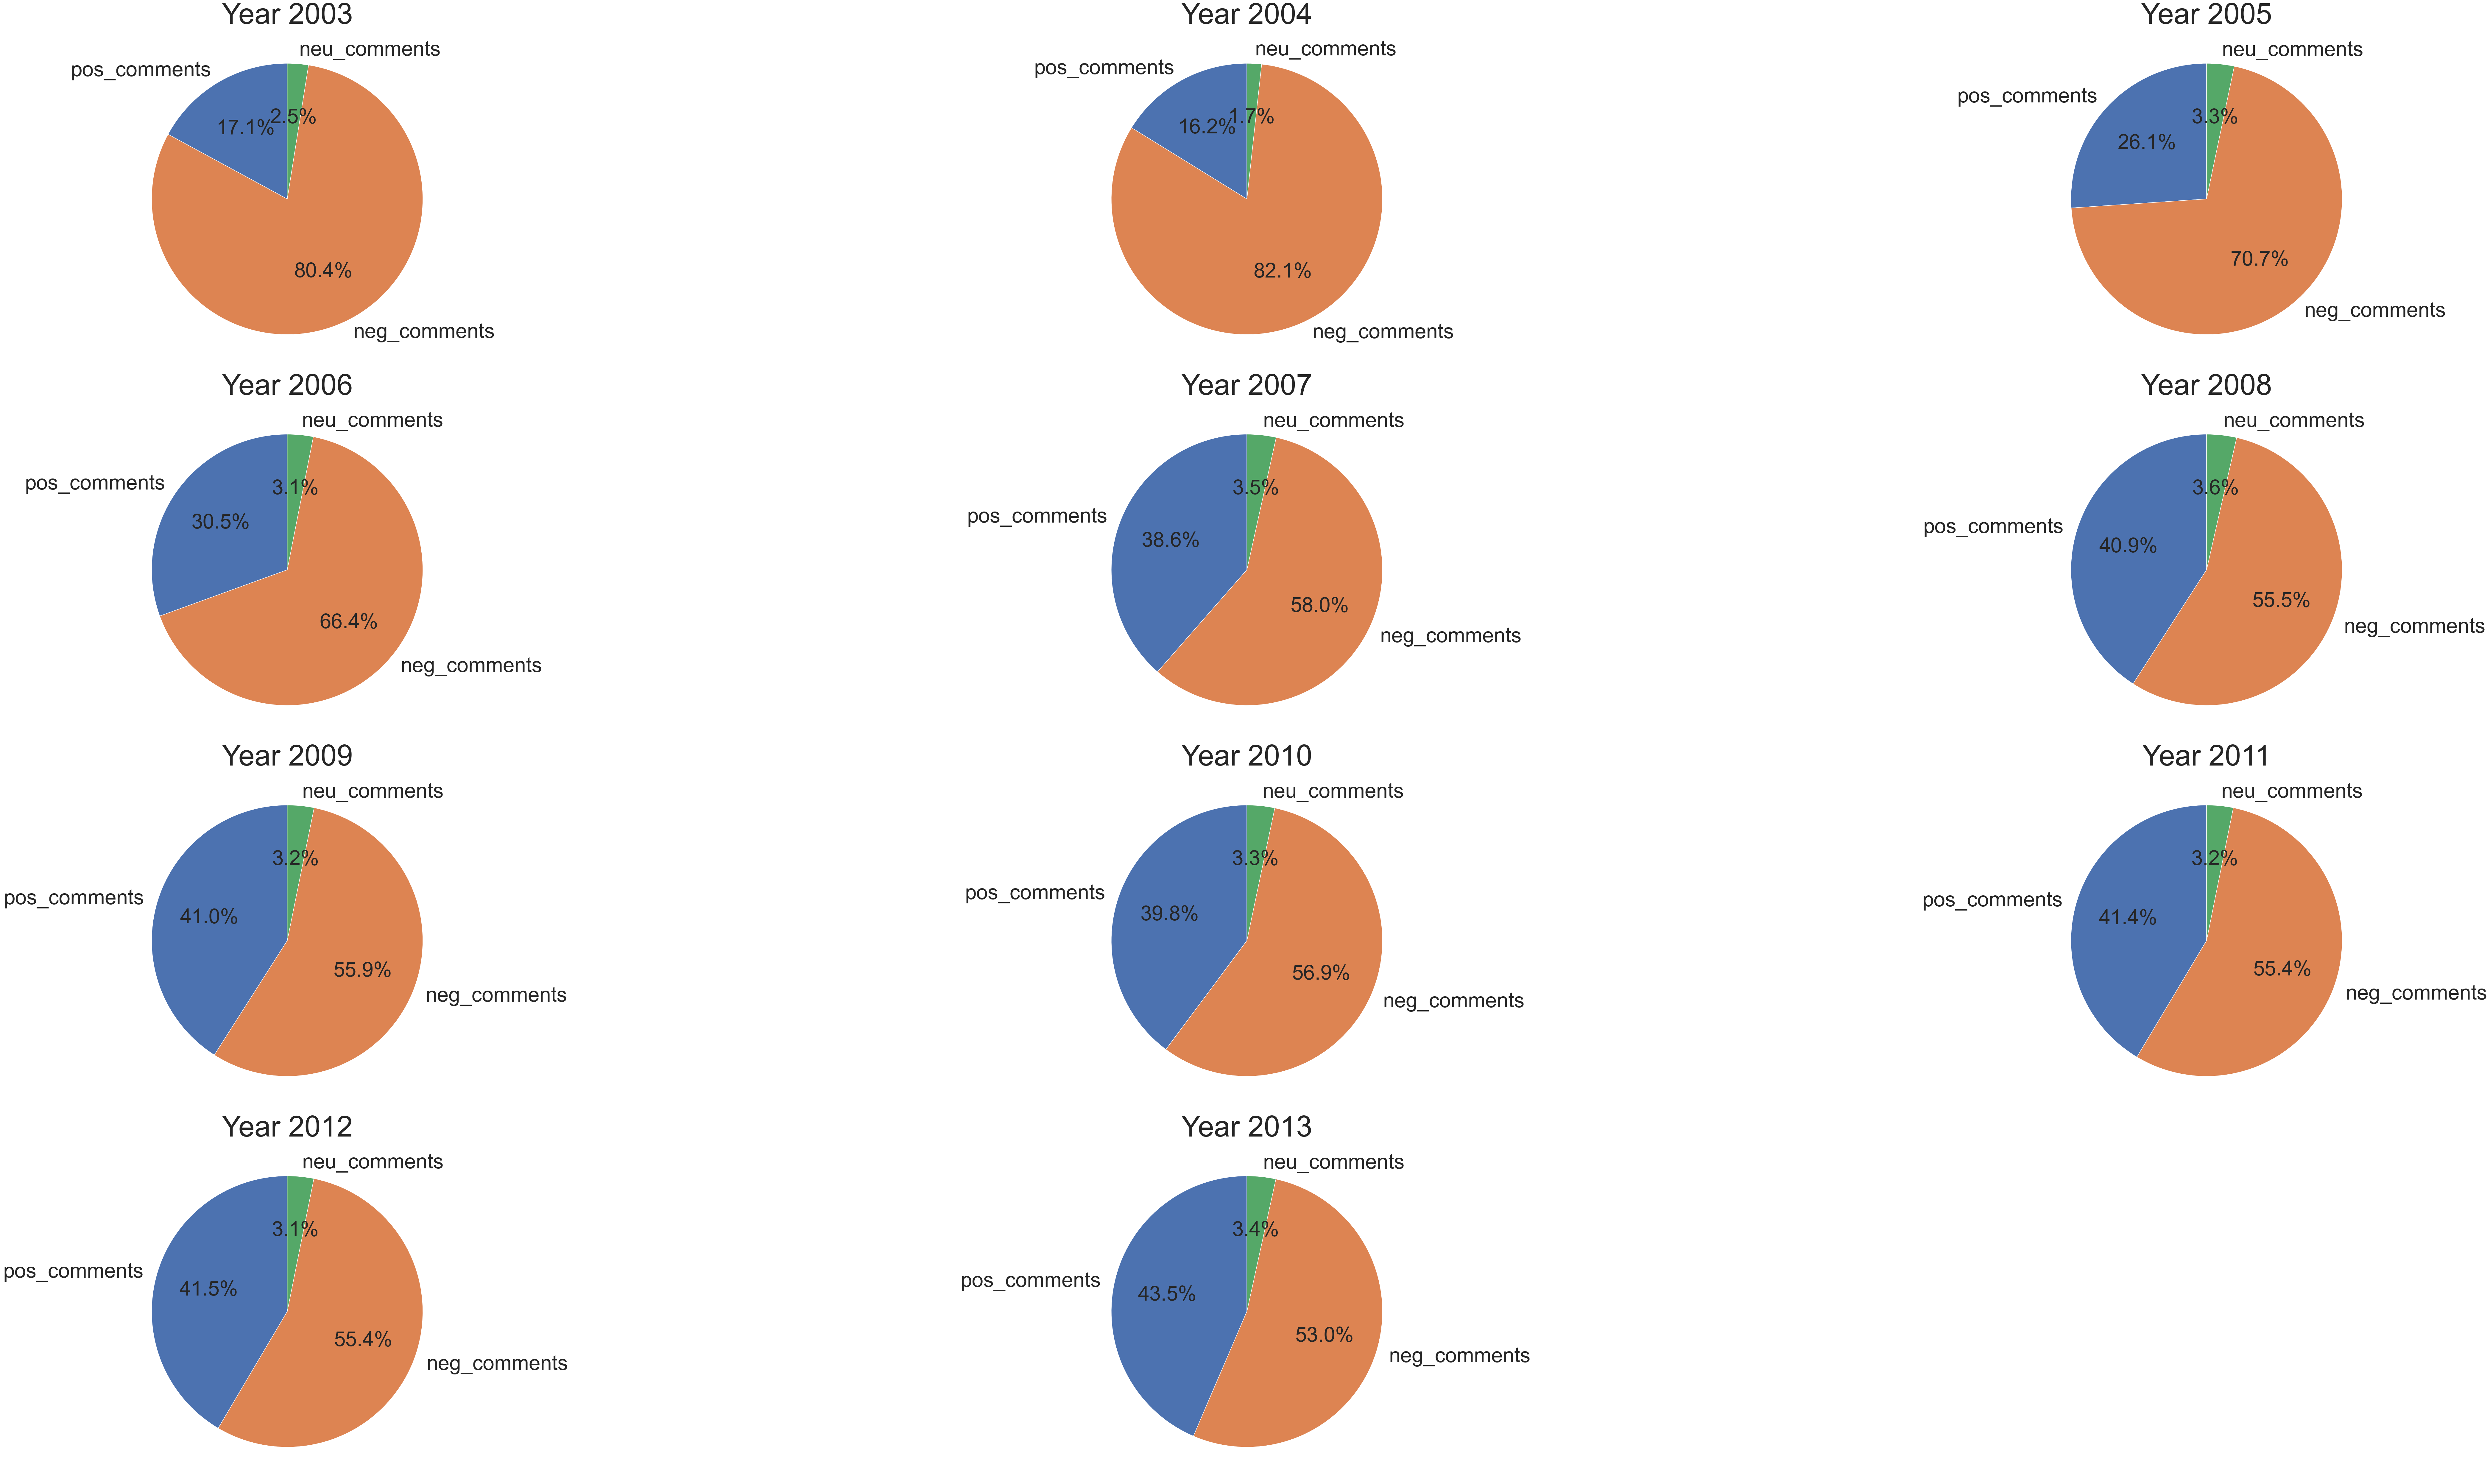

In [ ]:
# Pie chart of the positive-neutral-negative comments proportion per year
pieChart_perYear_sentiment_score(df_sentiment)

Années 2004-2005-2006 un peu hors du lot mais.. Pas grand chose à dire

### Community & sentiment

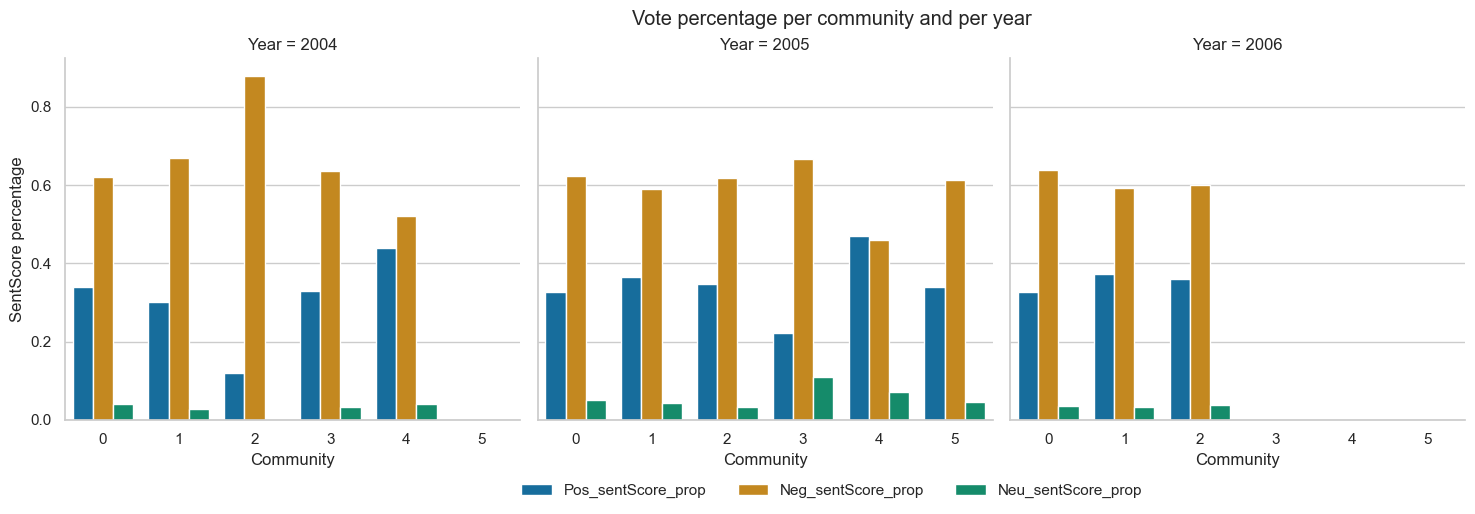

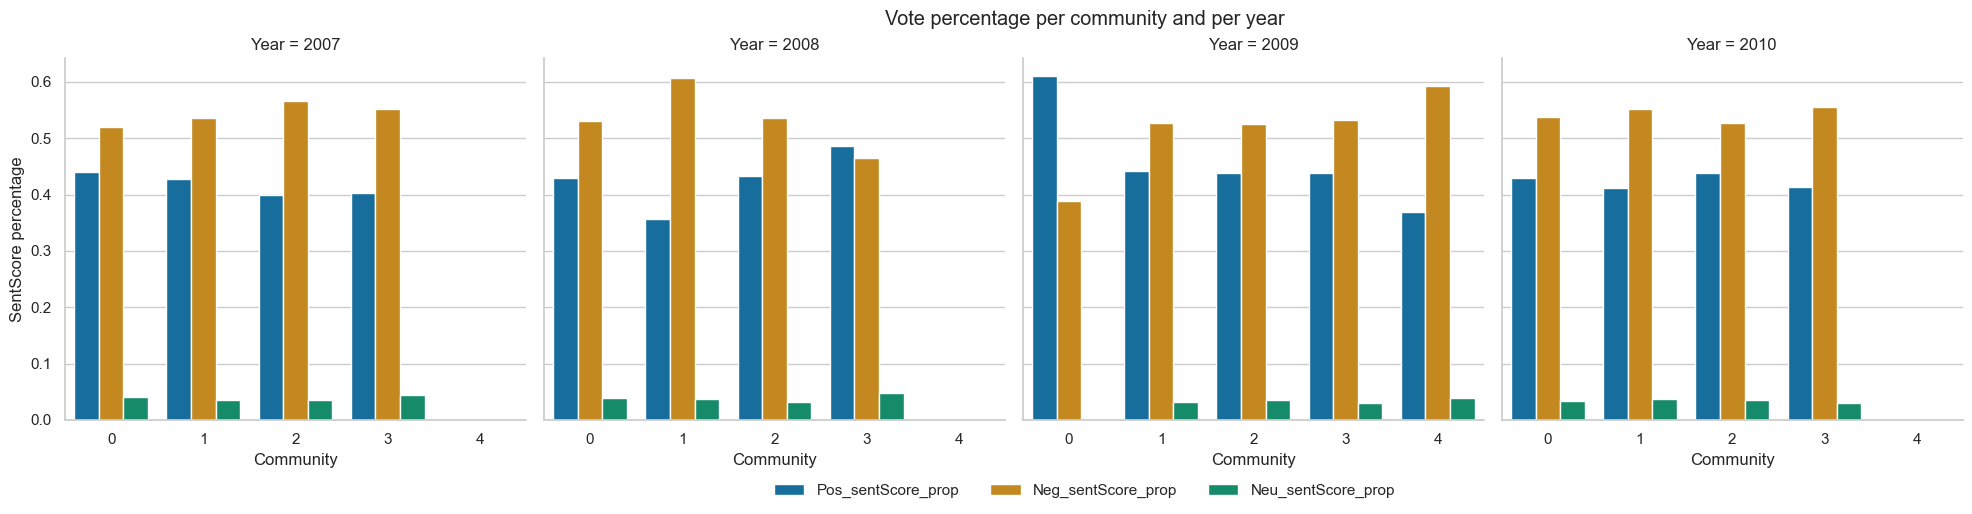

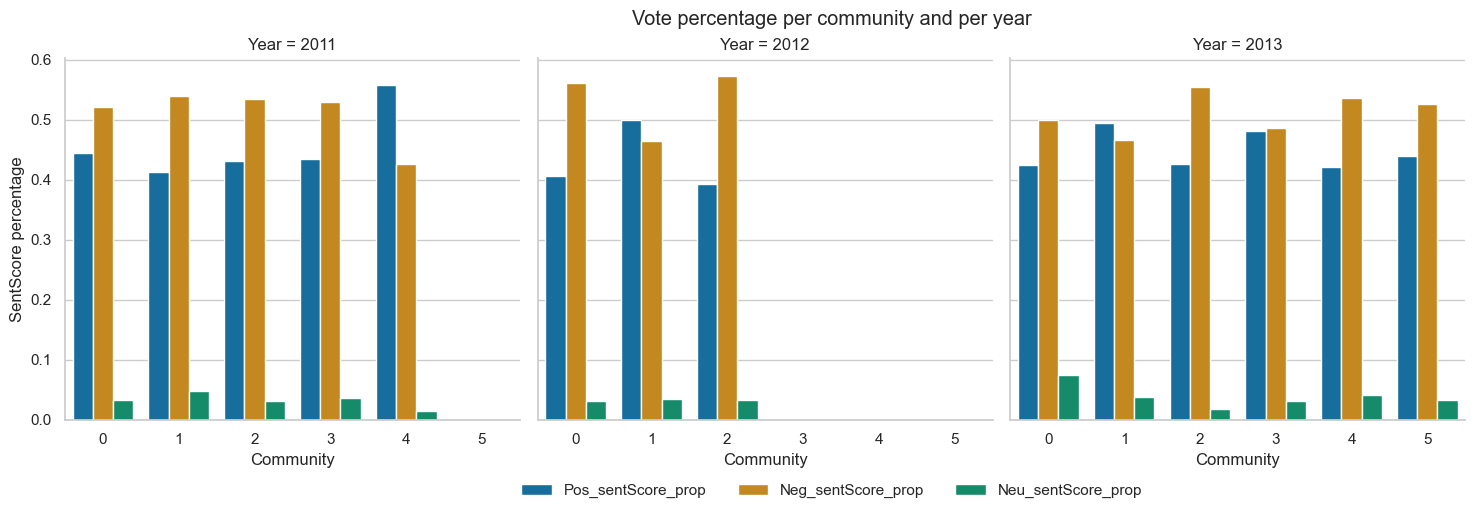

In [ ]:
# Computing the communities per year for the sentiment analysis
df_stat_com = community_sentiment_analysis_per_year(df_sentiment)

# Plotting for each year
plot_dist_sentScore_per_com(df_stat_com, [2004,2005,2006])
plot_dist_sentScore_per_com(df_stat_com, [2007,2008,2009,2010])
plot_dist_sentScore_per_com(df_stat_com, [2011,2012,2013])

We will now also use the scores obtained via the sentiment analysis for each vote to run the analysis on the voting time and compare the results we get with the ones obtained with only the votes.

# Quantity of votes through time

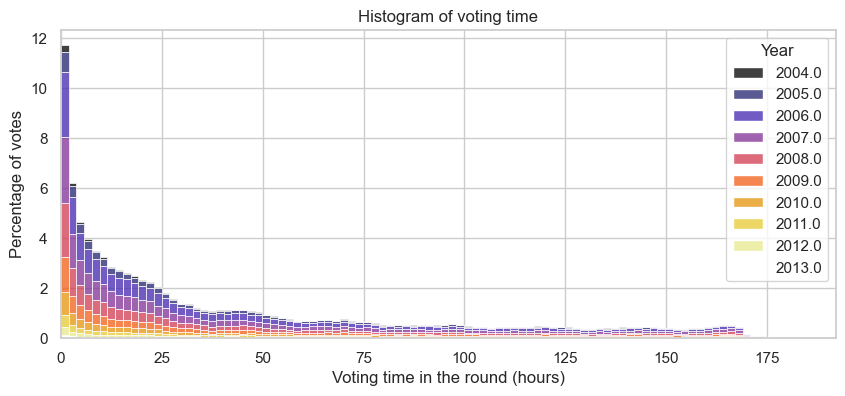

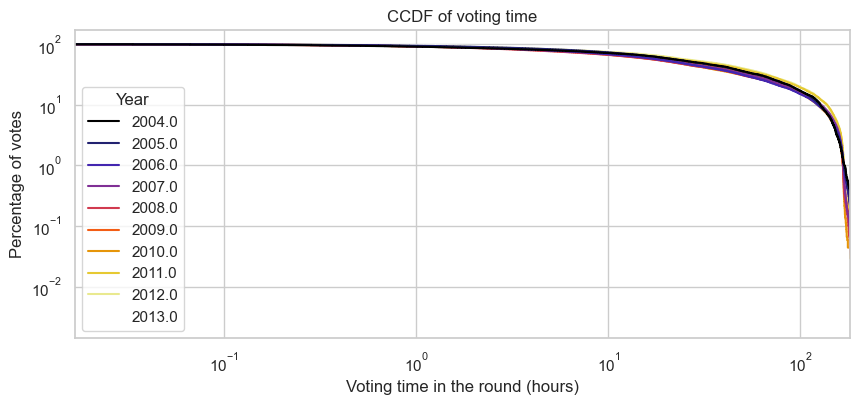

In [ ]:
# Distribution of votes in round of election
pdf_voting_time(df_vote_evolution)
cdf_voting_time(df_vote_evolution)

# Per community
for year, comm in communities:
    df_comm = df_vote_evolution_comm[(df_vote_evolution_comm['Year'] == year) & (df_vote_evolution_comm['Community'] == comm)]
    pdf_voting_time(df_comm, 'comm_' + str(year) + '_' + str(comm))
    cdf_voting_time(df_comm, 'comm_' + str(year) + '_' + str(comm))

We checked the distribution of voting time of each vote. We can see that the distribution is heavy tailed but bounded (due to the decision we made to split the vote into round of election). To assess whether the distribution is a power law we plot the complementary cumulative distribution function (CCDF) of the voting time in a log-log scale but this plot does not show a linear behavior. We can conclude that the distribution is not a power law.

# Evolution of votes proportions through time

In [ ]:
# Add the sentiment analysis to the voting evolution dataframe
df_vote_evolution = df_vote_evolution.merge(df_sentiment, on=['Target', 'Source', 'Date'], how='left')
df_vote_evolution.sample(5)

In [ ]:
df_vote_evolution = get_progressive_mean(df_vote_evolution)
df_vote_evolution.sample(5)

df_vote_evolution_comm = get_progressive_mean_comm(df_vote_evolution_comm, communities)

TypeError: Series.sort_values() takes 1 positional argument but 2 were given

To evaluate the progression of the election in function of the incoming votes we compute the progressive mean for each target and each round of election. 

#### Tendencies, center and dispersion

Using the progressive mean we now want to compare the evolution of the election between target that are accepted and target that are rejected. In this end, we compute the median and first and last quartiles of the progressive mean as well as the mean and 95% confidence interval. We do this in function of the voting time using a rolling average, as well as in function of the number of votes casted to have a better idea of the evolution of the election and also to see if the pattern is different if considering the timing of the votes or the order of the votes. 

In [ ]:
df_vote_evolution_comm[(df_vote_evolution_comm['Year'] == 2005) & (df_vote_evolution_comm['Community'] == 3)]

In [ ]:
df_vote_evolution_comm[df_vote_evolution_comm['Community'] == 3]

In [ ]:
# Moving average of the progressive mean by filtering the data with a window of 1 hour
rolling_avg = df_vote_evolution.groupby(['Results', pd.Grouper(key='Voting_time', freq='1h', origin='start')])

# Compute the median, first and last quartile
quartiles = get_quartiles(rolling_avg, 'Voting_time')

# Compute the mean and 95% confidence interval
sem = get_confidence_interval(rolling_avg, 'Voting_time')

# Display the results
display(quartiles.sample(5))
display(sem.sample(5))

quartiles_comm = {}
sem_comm = {}
for year, comm in communities:
    df_comm = df_vote_evolution_comm[(df_vote_evolution_comm['Year'] == year) & (df_vote_evolution_comm['Community'] == comm)]
    rolling_avg = df_comm.groupby(['Results', pd.Grouper(key='Voting_time', freq='1h', origin='start')])
    quartiles_comm[(year, comm)] = get_quartiles(rolling_avg, 'Voting_time')
    sem_comm[(year, comm)] = get_confidence_interval(rolling_avg, 'Voting_time')

In [ ]:
# Plot the evolution of the median, first and last quartile of the progressive mean
ax = plot_vote_evolution(quartiles, 'Voting_time')
ax.set_title('Evolution of the median, first and last quartile of the progressive mean')
plt.savefig('Figures/median_quartiles_over_time.png')
plt.show()

# Plot the evolution of the mean and 95% confidence interval of the progressive mean
ax = plot_vote_evolution(sem, 'Voting_time')
ax.set_title('Evolution of the mean and 95% confidence interval of the progressive mean')
plt.savefig('Figures/mean_ci_over_time.png')
plt.show()

# Per community
for year, comm in communities:
    ax = plot_vote_evolution(quartiles_comm[(year, comm)], 'Voting_time')
    ax.set_title('Evolution of the median, first and last quartile of the progressive mean')
    plt.savefig('Figures/median_quartiles_over_time_comm_' + str(year) + '_' + str(comm) + '.png')
    plt.close()

    ax = plot_vote_evolution(sem_comm[(year, comm)], 'Voting_time')
    ax.set_title('Evolution of the mean and 95% confidence interval of the progressive mean')
    plt.savefig('Figures/mean_ci_over_time_comm_' + str(year) + '_' + str(comm) + '.png')
    plt.close()


In [ ]:
# Election evolution by vote number
vote_nb = df_vote_evolution.groupby(['Results', 'Vote_number'])
# Compute the median, first and last quartile
quartiles = get_quartiles(vote_nb, 'Vote_number')

# Compute the mean and 95% confidence interval
sem = get_confidence_interval(vote_nb, 'Vote_number')

# Display the results
display(quartiles.sample(5))
display(sem.sample(5))

quartiles_comm = {}
sem_comm = {}
for year, comm in communities:
    df_comm = df_vote_evolution_comm[(df_vote_evolution_comm['Year'] == year) & (df_vote_evolution_comm['Community'] == comm)]
    vote_nb = df_comm.groupby(['Results', 'Vote_number'])
    quartiles_comm[(year, comm)] = get_quartiles(vote_nb, 'Vote_number')
    sem_comm[(year, comm)] = get_confidence_interval(vote_nb, 'Vote_number')

In [ ]:
# Plot the evolution of the median, first and last quartile of the progressive mean
ax = plot_vote_evolution(quartiles, 'Vote_number')
ax.set_title('Evolution of the median, first and last quartile of the progressive mean')
plt.savefig('Figures/median_quartiles_over_n_votes.png')
plt.show()

# Plot the evolution of the mean and 95% confidence interval of the progressive mean
ax = plot_vote_evolution(sem, 'Vote_number')
ax.set_title('Evolution of the mean and 95% confidence interval of the progressive mean')
plt.savefig('Figures/mean_ci_over_n_votes.png')
plt.show()

# Per community
for year, comm in communities:
    df_comm = df_vote_evolution_comm[(df_vote_evolution_comm['Year'] == year) & (df_vote_evolution_comm['Community'] == comm)]
    vote_nb = df_comm.groupby(['Results', 'Vote_number'])
    ax = plot_vote_evolution(quartiles_comm[(year, comm)], 'Vote_number')
    ax.set_title('Evolution of the median, first and last quartile of the progressive mean')
    plt.savefig('Figures/median_quartiles_over_n_votes_comm_' + str(year) + '_' + str(comm) + '.png')
    plt.close()
    
    ax = plot_vote_evolution(sem_comm[(year, comm)], 'Vote_number')
    ax.set_title('Evolution of the mean and 95% confidence interval of the progressive mean')
    plt.savefig('Figures/mean_ci_over_n_votes_comm_' + str(year) + '_' + str(comm) + '.png')
    plt.close()

The resulting plots show a clear difference between the evolution of the election for accepted and rejected targets, in particular we can see that the interquartile ranges do not overlap. Additionally, we can note that the gap between the two groups reagrding mean and median is actually larger at the begining of the election and then reduces (the values for the accepted targets decrease and the values for the rejected ones increase). These observations are good indicators of a clear difference between the two groups: it looks like in a large majority of cases the decision to accept or not the target is globally consensual and the outcome of the election can be predicted early on in the process.

#### Scatter plots and density

To have a better comprehension of the evolution of the election we also plot the histogram of the progressive mean for each target and each round of election. Note that we use a log scale for the count of votes to have a better visualization of the distribution being heavy tailed. Same as before, we plot the histogram in function of the voting time and in function of the number of votes casted for the accepted and rejected targets separately. 

In [ ]:
plot_time_distribution(df_vote_evolution, 'Voting_time')
plot_time_distribution(df_vote_evolution, 'Vote_number')

# Per community
for year, comm in communities:
    df_comm = df_vote_evolution_comm[(df_vote_evolution_comm['Year'] == year) & (df_vote_evolution_comm['Community'] == comm)]
    plot_time_distribution(df_comm, 'Voting_time', 'comm_' + str(year) + '_' + str(comm))
    plot_time_distribution(df_comm, 'Vote_number', 'comm_' + str(year) + '_' + str(comm))

With these plots we can see that even though the distribution of the progressive mean for the rejected targets is more spread out and lower than the one for the accepted targets, there is still numerous cases where both groups overlap.  

# Prediction of the results based on early votes

To have a better quantification of how early the outcome of the election can be predicted we compute the probability of a target to be accepted based on the progressive mean of the first votes and using a Gradient Boosting Classifier. To assess the performance of the model we compute several metrics: accuracy, precision, recall that we then plot in function of the number of first votes used to do the prediction. We also show the confidence interval of the measure we got using cross-validation.

In [ ]:
if False: # Takes a 40 minutes to run
    nb_first_votes = np.concatenate((np.arange(1,5), np.arange(5, 71, 5)))
    # Predict the result for each target with the first 5, 10, 15, ..., 50 votes using a gradient boosting classifier and cross validation to evaluate the performance
    scores = early_vote_prediction(df_vote_evolution, nb_first_votes, 10)
    # Save the results
    scores.to_csv('scores.csv', index=False)

In [ ]:
scores = pd.read_csv('scores.csv')
plot_prediction_scores(scores)

The accuracy is relatively high (around 0.87 at the plateau) but knowing the imbalance of the dataset between accepted and rejected targets (around 62% of the targets are accepted) we prefer to look at the precision and recall. Moreover, to have a better understanding of what shapes the election process it is particularly interesting to examine the reasons why some users are likely to be rejected.
And actually the curve of the recall is notably higher than the one of the accuracy (around 0.95 at the plateau but relatively stable from the beginning) whereas the curve of the precision is more similar to the one of the accuracy. 

# Analysis of the sources

In [ ]:
plot_nb_votes_per_source(df_vote_evolution)

# Per community
for year, comm in communities:
    df_comm = df_vote_evolution_comm[(df_vote_evolution_comm['Year'] == year) & (df_vote_evolution_comm['Community'] == comm)]
    plot_nb_votes_per_source(df_comm, 'comm_' + str(year) + '_' + str(comm))

In [ ]:
df_source = get_source_df(df_vote_evolution)
df_source.sample(5)

# Per community
df_source_comm = get_source_df(df_vote_evolution_comm)

In [ ]:
# Distribution of the number of votes per source (histogram)
plot_mean_std_time(df_source)

# Per community
for year, comm in communities:
    df_comm = df_source_comm[(df_source_comm['Year'] == year) & (df_source_comm['Community'] == comm)]
    plot_mean_std_time(df_comm, 'comm_' + str(year) + '_' + str(comm))